In [1]:
import os
import numpy as np
import pandas as pd
import itertools  
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# from utils_cython.data_utils_c import derivative
from utils.data_utils import (csvs_merge, cumsum, step_change_point, 
                              hankel_svd, correlation_coeffs, Bearing)

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

In [2]:
step = 2560

In [34]:
# bearings_to_read = ['Bearing1_1', 'Bearing1_2', 'Bearing1_4', 'Bearing1_5', 
#                     'Bearing1_6', 'Bearing1_7', 'Bearing2_1', 'Bearing2_2', 'Bearing2_3', 
#                     'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7', 'Bearing3_1', 
#                     'Bearing3_2', 'Bearing3_3']

# bearings_to_read = ['Bearing1_1', 'Bearing1_2', 'Bearing1_4', 'Bearing1_5']
    
bearings_to_read = ['Bearing1_7']
    
dataset = 'femto_dataset'
bearings = []
for bearing_to_read in bearings_to_read:
    data = {'vib' : pd.read_csv('../femto_dataset/%s/acc_merged.csv' % (bearing_to_read))}
    
    # Reads 'temperature' if the data exists.
#     if os.path.exists('../femto_dataset/%s/temp_merged.csv' % (bearing_to_read)):
#             data['temp'] = pd.read_csv('../femto_dataset/%s/temp_merged.csv' % ( bearing_to_read))
    
    bearings.append(Bearing(name=bearing_to_read, dataset=dataset,
                            condition=bearing_to_read[7], data=data, restore_results=False))

# bearings = pd.read_csv('../femto_dataset/{}/acc_merged.csv'.format(bearings_to_read[0]))
# bearings

In [35]:
# Starting with cumsum and derivative analysis.
for bearing in bearings:
    # Computing cumsum.
    bearing.results['cumsum'] = {'h' : cumsum(bearing.data['vib']['h_acc']), 
                                 'v' : cumsum(bearing.data['vib']['v_acc'])}
    
    # Computing cumsum derivative.
#     h = 39*10**-6 # Distance between points - It's in original data in u-sec column.
#     bearing.results['cs_derivative'] = {'h' : np.asarray(derivative(bearing.results['cumsum']['h'].values, h)), 
#                                         'v' : np.asarray(derivative(bearing.results['cumsum']['v'].values, h))}
    
#     # Marking change points (cp) in derivative.
#     bearing.results['cs_deriv_cp'] = {'h' : step_change_point(bearing.results['cs_derivative']['h']),
#                                       'v' : step_change_point(bearing.results['cs_derivative']['v'])}

In [36]:
for bearing in bearings:
    # Compute hankel matrix singular values.
    bearing.results['hankel_svd'] = {'h' : hankel_svd(bearing.data['vib']['h_acc'], window_size=9,
                                                      n_samples=len(bearing.data['vib']['h_acc'])//step),
                                     
                                     'v' : hankel_svd(bearing.data['vib']['v_acc'], window_size=9, 
                                                      n_samples=len(bearing.data['vib']['v_acc'])//step)}
    
    # Compute correlation coefficients.
    bearing.results['hankel_svd_correlation_coeffs'] = {'h' : correlation_coeffs(bearing.results['hankel_svd']['h'], 
                                                        baseline=0, norm_interval=[-1, 1]),
                                                  
                                                 'v' : correlation_coeffs(bearing.results['hankel_svd']['v'],
                                                        baseline=0, norm_interval=[-1, 1])}

In [37]:
bearings[0].results.keys()

dict_keys(['cumsum', 'hankel_svd', 'hankel_svd_correlation_coeffs'])

In [38]:
hankel_spot = pd.DataFrame(bearings[0].results['hankel_svd_correlation_coeffs']['v'], columns=['hankel_v'])
aux = hankel_spot.query('hankel_v < 0.6').index[0]
aux

2230

In [39]:
def get_explosion_index(df, target):
    highest = 0
    target_index = 0
    for i in range(target-200, target):
        if df.hankel_v.iloc[i] < 0.95:
            if highest < df.hankel_v.iloc[i]:
                highest = df.hankel_v.iloc[i]
                target_index = i
#             print(str(i) + ' {}'.format(linear.hankel_v.iloc[i]))
    return target_index

In [40]:
explosive = get_explosion_index(hankel_spot, aux)
explosive

2214

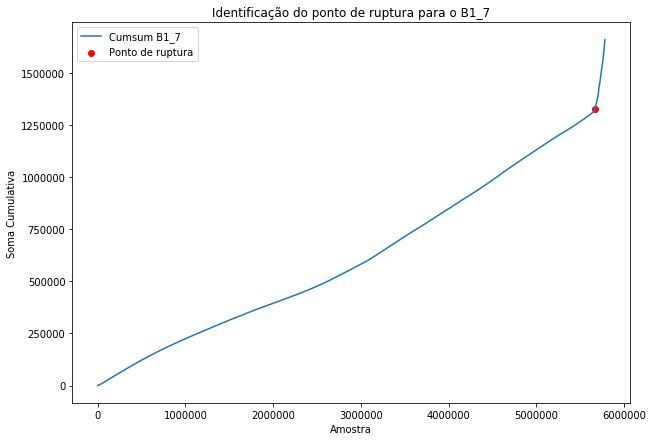

In [52]:
br = bearings[0].results['cumsum']['v']
f, ax = plt.subplots(figsize=(10,7))
ax.plot(br, label='Cumsum B1_7')
ax.scatter(step*explosive, br[step*explosive], c='r', label='Ponto de ruptura')
ax.set_title('Identificação do ponto de ruptura para o B1_7')
ax.set_xlabel('Amostra')
ax.set_ylabel('Soma Cumulativa')
ax.legend(loc='upper left')

plt.savefig('ruptura_B1_7.png', dpi=500)
plt.show()

In [ ]:
def do_all_stuff(bearing_train, bearing_test, qtd, degree):
    
    # ---- TRAIN ---- #
    hankel_spot = pd.DataFrame(bearing_train.results['hankel_svd_correlation_coeffs']['v'], columns=['hankel_v'])
    aux = hankel_spot.query('hankel_v < 0.6').index[0]
    
    expon = bearing_train.results['cumsum']['v'][step*get_explosion_index(hankel_spot, aux):]
    
    scaler = MinMaxScaler()
    expon = expon.values.reshape(-1,1)
    expon = scaler.fit_transform(expon)
    expon[-1]
    expon = np.hstack(expon)
    
    target_reg_expon = np.linspace(1, 0, len(expon))
    
    interpol = np.linspace(0, 1, len(expon))
    

    step_temp = len(expon)//qtd
    tamanho = step_temp
    coefs = []
    for window in range(0, qtd):
        janela = expon[window*step_temp:(window+1)*step_temp]
        jan_target = interpol[window*step_temp:(window+1)*step_temp]
        coefs.append(np.polyfit(janela, jan_target, degree))
        
    target_reg_expon = np.linspace(1, 0, len(coefs))

    reg = RandomForestRegressor(n_estimators=100, random_state=42)
    reg.fit(coefs, target_reg_expon)
    reg.score(coefs, target_reg_expon)
    score_train = reg.score(coefs, target_reg_expon)
    # ---- TEST ---- #
    
    hankel_spot = pd.DataFrame(bearing_test.results['hankel_svd_correlation_coeffs']['v'], columns=['hankel_v'])
    aux = hankel_spot.query('hankel_v < 0.6').index[0]
    
    offset = step*get_explosion_index(hankel_spot, aux)
    
    linear = bearing_test.results['cumsum']['v'][0:offset]
    expon = bearing_test.results['cumsum']['v'][offset:]
    
    scaler = MinMaxScaler()
    expon = expon.values.reshape(-1,1)
    expon = scaler.fit_transform(expon)
    expon[-1]
    expon = np.hstack(expon)
    
    target_reg_expon = np.linspace(1, 0, len(expon))
    
    interpol = np.linspace(0, 1, len(expon))
    step_temp = len(expon)//qtd
    tamanho = step_temp
    
    #Comment from here to plot one coefs to another
    coefs = []
    for window in range(0, qtd):
        janela = expon[window*step_temp:(window+1)*step_temp]
        jan_target = interpol[window*step_temp:(window+1)*step_temp]
#         plt.plot(janela, jan_target)
#         if window >= 0:
#             break
        coefs.append(np.polyfit(janela, jan_target, degree))
        
    
    target_reg_expon = np.linspace(1, 0, len(coefs)).reshape(-1,1)
#     target_reg_expon = target_reg_expon
    
    score_test = reg.score(coefs, target_reg_expon)
    
    return  score_test, coefs, step_temp, offset, scaler, expon, reg

In [99]:
qtdd = 1000
score, coefs, step_temp, ofs, scaler_test, expon, reg = do_all_stuff(bearings[9], bearings[0], qtd=qtdd, degree=2)
print(score)
print(ofs)

0.9696522690594691
7121920


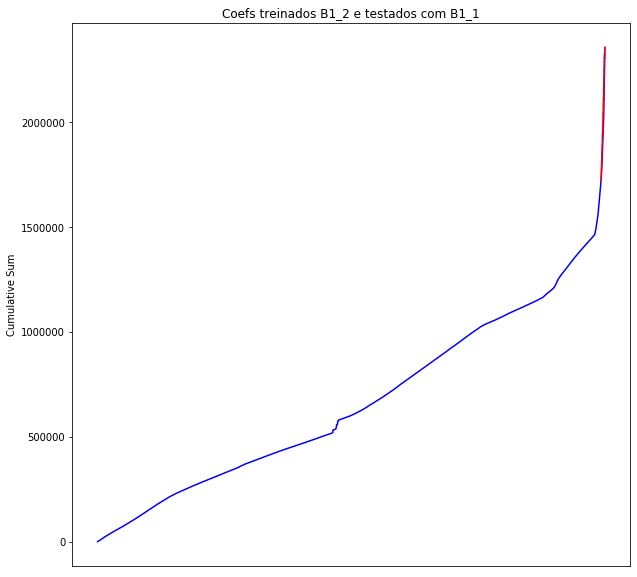

In [19]:
f, ax = plt.subplots(figsize=(10,10))
ax.plot(bearings[0].results['cumsum']['v'], c='b')

# 1000 windows
for i in range(0,qtdd):
    
    # Get normalized x vector
    x = expon[i*step_temp:(i+1)*step_temp]
    
    # Calculate all y
    y = np.array([coefs[i][0]*e**2 + coefs[i][1]*e + coefs[i][2] for e in x])
        
    # De-normalize x
    x_dn = [ofs + a for a in range(i*step_temp,(i+1)*step_temp)]

    # De-normalize y
    y_dn = scaler_test.inverse_transform(y.reshape(-1,1))
    
    ax.plot(x_dn, y_dn, c='r')
# plt.xlim([2170000,2250000])
# plt.ylim([600000,1300000])
# ax.set_xlim([7100000,len(bearings[0].results['cumsum']['v'])+10000])
# ax.set_ylim([1500000,2600000])
ax.set_ylabel('Cumulative Sum')
ax.set_title('Coefs treinados B1_2 e testados com B1_1')
ax.set_xticks([])
plt.show()

In [37]:
def lifetime_predict(bearing, regressor, qtd, degree):
    
    # ---- Predict ---- #
    hankel_spot = pd.DataFrame(bearing.results['hankel_svd_correlation_coeffs']['v'], columns=['hankel_v'])
    aux = hankel_spot.query('hankel_v < 0.6').index[0]
    
    expon = bearing.results['cumsum']['v'][step*get_explosion_index(hankel_spot, aux):]
    
    scaler = MinMaxScaler()
    expon = expon.values.reshape(-1,1)
    expon = scaler.fit_transform(expon)
    expon[-1]
    expon = np.hstack(expon)
    
    interpol = np.linspace(0, 1, len(expon))
    
    step_temp = len(expon)//qtd
    tamanho = step_temp
    coefs = []
    for window in range(0, qtd):
        janela = expon[window*step_temp:(window+1)*step_temp]
        jan_target = interpol[window*step_temp:(window+1)*step_temp]
        coefs.append(np.polyfit(janela, jan_target, degree))
        
    return regressor.predict(coefs)

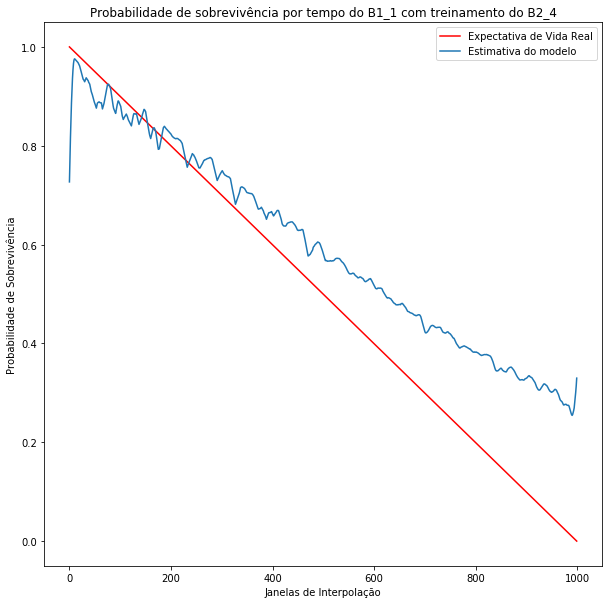

In [105]:
res = lifetime_predict(bearings[13], reg, qtd=qtdd, degree=2)

from scipy.signal import filtfilt

n = 10  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy = filtfilt(b,a,res)
# plt.plot(x, yy, linewidth=2, linestyle="-", c="b")  # smooth by filter

f, ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,0,qtdd), c='r', label='Expectativa de Vida Real')
ax.plot(yy, label='Estimativa do modelo')
ax.legend()
ax.set_ylabel('Probabilidade de Sobrevivência')
ax.set_xlabel('Janelas de Interpolação')
ax.set_title('Probabilidade de sobrevivência por tempo do B1_1 com treinamento do B2_4')
plt.savefig('sobrevivenciaB31_B24.png', dpi=500)
plt.show()